In [1]:
import os
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
# from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input


In [2]:
# Chargement du script d'importation et formattage des images
%run ./data-importation-and-formatting-v2.py

In [3]:
# Chargement du script de séparation des données
%run ./train_val_test_split.py

In [4]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Lung Opacity", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


In [5]:
print("IMG_SIZE = ", IMG_SIZE)  # Peut être changée dans le code data-importation-and-formatting-v2

IMG_SIZE =  299


## Importation et préparation des données

In [6]:
## Importation des images
SAMPLE_SIZE = 2500
sample_size_viral_pneum = np.min([1345, SAMPLE_SIZE])
sample_size_lung_opa = SAMPLE_SIZE - sample_size_viral_pneum
masked_img_df = load_masked_img_multiple_cond_in_df(selected_conditions=conditions, sample_sizes=[sample_size_viral_pneum, sample_size_lung_opa, SAMPLE_SIZE, SAMPLE_SIZE])


In [7]:
masked_img_df.replace({'Viral Pneumonia' : 'Pulmonary infection',
                       'Lung_Opacity' : 'Pulmonary infection'}, inplace=True)

In [8]:
masked_img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

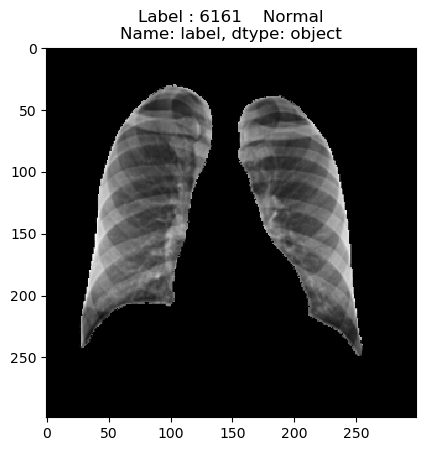

In [9]:
ind = random.sample(range(0,masked_img_df.shape[0]),1)
plt.imshow(np.array(masked_img_df.drop(columns='label').iloc[ind,:]).reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.title(f"Label : {masked_img_df.label[ind]}");

In [ ]:
masked_img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

## Séparation en échantillons d'apprentissage, de validation et de test

In [10]:
X = masked_img_df.drop(columns='label')/IMG_SIZE
y = masked_img_df.label

# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(y)
print(labenc.classes_)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

['COVID' 'Normal' 'Pulmonary infection']


In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Modélisation

### Data augmentation

In [13]:
BATCH_SIZE = 64 


train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

val_datagen = ImageDataGenerator()

## Reshaping des images pour correspondre au format couleur pour l'intégration dans VGG
X_train_3 = np.repeat(np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)
X_val_3 = np.repeat(np.array(X_val).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)

train_dataset = train_datagen.flow(X_train_3,
                                   y_train,
                        batch_size = BATCH_SIZE)


val_dataset = val_datagen.flow(X_val_3, y_val, batch_size = BATCH_SIZE)

### Construction du modèle

In [14]:
pre_trained_model = VGG16(weights = 'imagenet', include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
for layer in pre_trained_model.layers[-4:]:
    layer.trainable = True

In [24]:
pre_trained_model.layers

In [15]:
model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
# model.add(Dense(units = 512, activation='relu'))
# model.add(Dropout(rate=0.3))
# model.add(Dense(units = 256, activation='relu'))
# model.add(Dropout(rate=0.2))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 64, activation = 'relu'))
# model.add(Dropout(rate=0.15))
# model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax')) #3

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #SparseCategoricalCrossentropy

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                               mode = 'min')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.1,
                                        patience = 3,
                                        min_delta = 0.01,
                                        cooldown = 4,
                                        verbose = 1)

callbacks_list = [early_stopping,reduce_learning_rate]

TODO : passer à 100 epochs

In [19]:
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
            validation_data = val_dataset, # use augmented images for test  
            validation_steps = X_val.shape[0]//BATCH_SIZE,
            epochs = 20,
            callbacks = callbacks_list,
            verbose=True)

#5h45

Epoch 1/20
75/75 [==============================] - 1343s 18s/step - loss: 1.1193 - acc: 0.3377 - val_loss: 1.1005 - val_acc: 0.3290 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 1325s 18s/step - loss: 1.0381 - acc: 0.4737 - val_loss: 0.9031 - val_acc: 0.6076 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 1325s 18s/step - loss: 0.8851 - acc: 0.5969 - val_loss: 0.7881 - val_acc: 0.6536 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 1328s 18s/step - loss: 0.8092 - acc: 0.6446 - val_loss: 0.7881 - val_acc: 0.6467 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 1333s 18s/step - loss: 0.7372 - acc: 0.6681 - val_loss: 0.6607 - val_acc: 0.6997 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 1322s 18s/step - loss: 0.6692 - acc: 0.7092 - val_loss: 0.6673 - val_acc: 0.6927 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 1323s 18s/step - loss: 0.6192 - acc: 0.7371 - val_loss: 0.5729 - val_acc

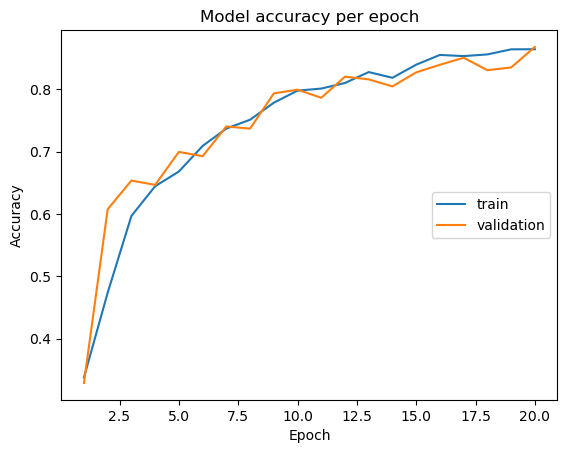

In [23]:
train_acc = model_history.history['acc'] 
val_acc = model_history.history['val_acc']

plt.plot(np.arange(1,21),train_acc, label='train')
plt.plot(np.arange(1,21),val_acc, label='validation')
plt.title('Model accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='right')


In [21]:
y_val_pred = model.predict(X_val_3)

38/38 [==============================] - 233s 6s/step


In [22]:
pred_class_val = y_val_pred.argmax(axis=1)
true_class_val = y_val.argmax(axis=1)
print(classification_report(true_class_val, pred_class_val))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85       371
           1       0.85      0.91      0.88       391
           2       0.91      0.85      0.88       438

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



### Evaluation des performances sur l'échantillon de test

In [26]:
X_test_3 = np.repeat(np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)

y_test_pred = model.predict(X_test_3)
pred_class_test = y_test_pred.argmax(axis=1)
true_class_test = y_test.argmax(axis=1)
print(classification_report(true_class_test, pred_class_test))

47/47 [==============================] - 302s 6s/step
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       492
           1       0.81      0.88      0.85       481
           2       0.90      0.84      0.87       527

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



In [28]:
f1_score(true_class_test, pred_class_test, average='micro')

0.8513333333333334

### Enregistrement du modèle

In [25]:
# Enregistrement du modèle entraîné
# model.save("../models/transfer-learning-models/vgg16_3classes_res299_20epochs")

# # vgg16model = load_model("../models/transfer-learning-models/vgg16_3classes_res299_20epochs")

# # X_test_3 = np.repeat(np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)

# # test_loss, test_acc = vgg16model.evaluate(X_test_3, y_test, verbose=2)



INFO:tensorflow:Assets written to: ../models/transfer-learning-models/vgg16_3classes_res299_20epochs\assets


INFO:tensorflow:Assets written to: ../models/transfer-learning-models/vgg16_3classes_res299_20epochs\assets
